### Just a Simple Place to Write Code/Test Things For the Moment
DELETE LATER!!!!

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yaml
import matplotlib.pyplot as plt

In [2]:
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
graph = config.graph
edges = config.graph['edges']
vertices = config.graph['vertices']
weight_dict = config.class_weights
height = config.graph['height']
root = config.graph['root']

/opt/miniconda3/envs/superphot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Graph in Question for messing around with

In [3]:
import networkx as nx
G = nx.DiGraph()

G.add_edge('SN-like', 'SN-gen')
G.add_edge('SN-like', 'TDE')

G.add_edge('SN-gen', 'SN')
G.add_edge('SN-gen', 'SN Ia-gen')
G.add_edge('SN Ia-gen', 'SN Ia')
G.add_edge('SN Ia-gen', 'SN Ia-91T')
G.add_edge('SN Ia-gen', 'SN Ia-91bg-like')
G.add_edge('SN Ia-gen', 'SN Ia-CSM')
G.add_edge('SN Ia-gen', 'SN Ia-SC')
G.add_edge('SN Ia-gen', 'SN Ia-pec')
G.add_edge('SN Ia-gen', 'SN Iax')


G.add_edge('SN-gen', 'CC')

G.add_edge('CC', 'SN II-gen')

G.add_edge('CC', 'SN Ib/c-gen')

G.add_edge('SN Ib/c-gen', 'SN Ib/c')

G.add_edge('SN Ib/c-gen', 'SN Ib-gen')
G.add_edge('SN Ib/c-gen', 'SN Ic-gen')

G.add_edge('SN Ib-gen', 'SN Ib-pec')
G.add_edge('SN Ib-gen', 'SN Ibn')
G.add_edge('SN Ib-gen', 'SN Ib')

G.add_edge('SN Ic-gen', 'SN Ic-BL')
G.add_edge('SN Ic-gen', 'SN Ic-Ca-rich')
G.add_edge('SN Ic-gen', 'SN Ic-pec')
G.add_edge('SN Ic-gen', 'SN Icn')
G.add_edge('SN Ic-gen', 'SN Ic')


G.add_edge('SN II-gen', 'SN IIn-like')
G.add_edge('SN IIn-like', 'SLSN-II')
G.add_edge('SN IIn-like', 'SN IIn')

G.add_edge('SN II-gen', 'SN II-like')
G.add_edge('SN II-like', 'SN II-pec')
G.add_edge('SN II-like', 'SN IIb')
G.add_edge('SN II-like', 'SN IIL')
G.add_edge('SN II-like', 'SN IIP')
G.add_edge('SN II-like', 'SN II')

G.add_edge('CC', 'SLSN-I')

In [4]:
"""
Hierarchy Position Encoder.
Taken from stackoverflow: https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3
(Used in hxe-for-tda)
"""

def hierarchy_pos(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        return pos
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})

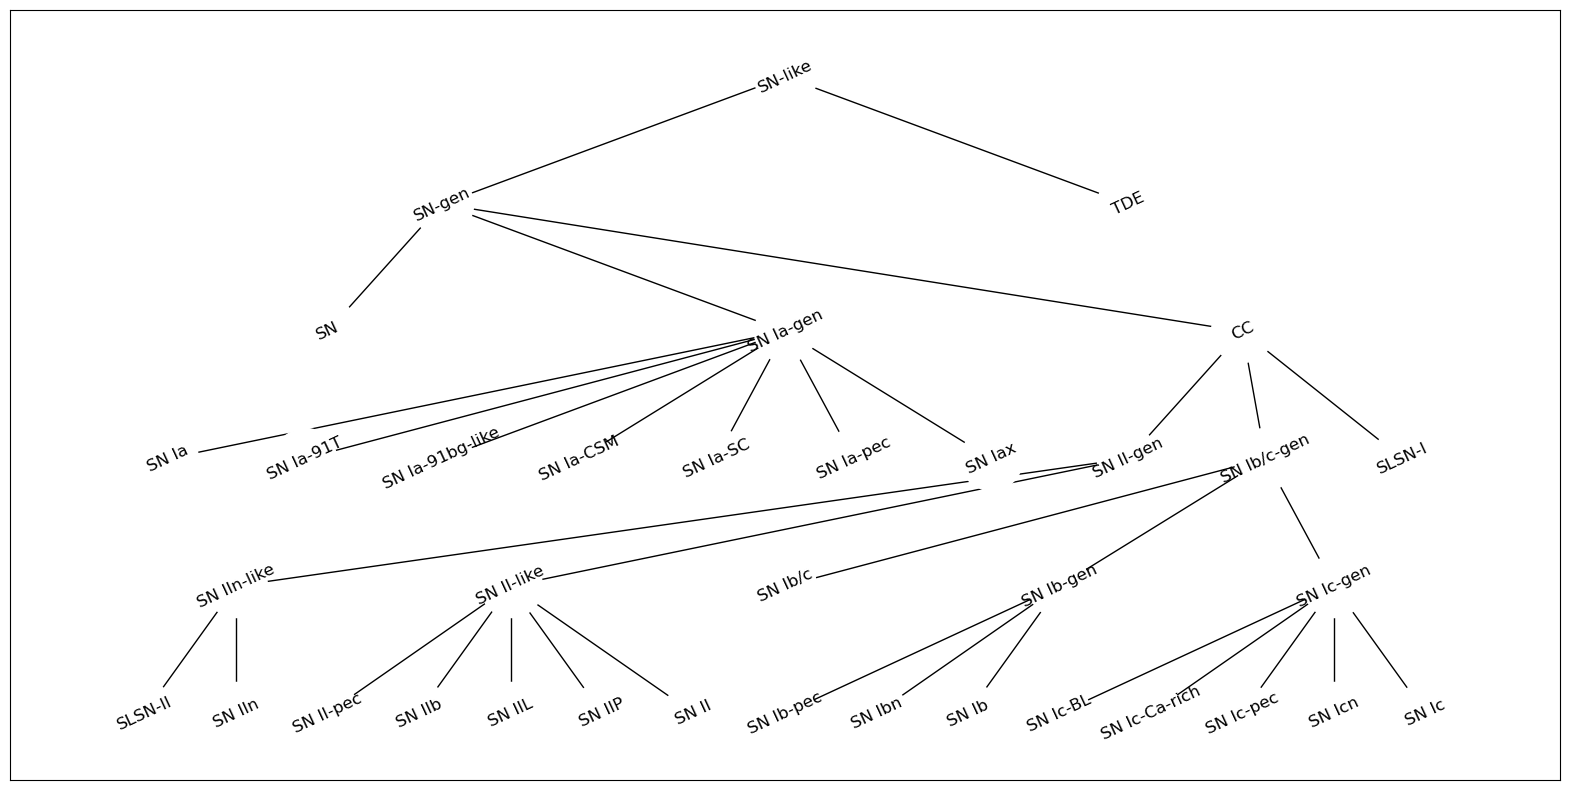

In [5]:
# Encode positions of graph - purely for drawing purposes
pos = hierarchy_pos(G, 'SN-like')
#print(pos)

fig = plt.figure(1, figsize=(20,10))
nx.draw_networkx(G, pos=pos, nodelist=vertices, node_color='white', with_labels=False, node_size=2000, arrows=False)
text = nx.draw_networkx_labels(G, pos)

#Uncomment if need to rotate the labels for a more advanced label system.
for _, t in text.items():
     t.set_rotation(25) 

plt.show()

### Messing Around with Graph

In [6]:
def bfs(G, s):
    
    def explore(X, F, i, fronteirs):
        if len(F) == 0: return (X, i-1, fronteirs)

        fronteirs[i] = F

        X = X.union(F)
        
        next_F = set()
        for u in F:
            for v in G.neighbors(u):
                if v not in X:
                    next_F.add(v)
        
        return explore(X, next_F, i+1, fronteirs)
    
    return explore(set(), {s}, 1, {}) 
    

In [7]:
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")

def tree_contract(G, graph, class_weights):

    # Builds a list of shortest paths from root to node from our trees
    # and groups into a dictionary such that paths of the same length
    # are kept together.
    paths = {}
    for node in graph['vertices']:
        path = nx.shortest_path(G, graph['root'], node)
        if (len(path)-1) not in paths.keys():
            paths[len(path)-1] = [path]
        else: paths[len(path)-1] += [path]

    # Iterate through the keys and for all that are for paths longer than 
    # config.height, we need to condense the weights to the appropriate
    # leveled parent
    mapping = {}
    counts = {}
    contractions = 0
    removals = []
    if graph['height'] > max(paths.keys())+1:
        # make sure the height is valid
        raise ValueError("Height cannot be bigger than the max height of the graph.")
    elif graph['height'] == max(paths.keys())+1:
        print('Using the full tree, no change.')
        return mapping, class_weights, graph, G
    else:
        # Update the weights & graph properties
        n_labels = len(class_weights) # this is the number of leaves/classes overall before we shrink
        n_all = sum([class_weights[i][1] for i in class_weights.keys()]) # get the sum of all numbers of instances
        _,_,fronteirs = bfs(G, graph['root'])

        for level in sorted(fronteirs.items(), reverse=True):
            if level[0] > graph['height']:
                for node in fronteirs[level[0]]:

                    # (1) find the path in paths that ends in node
                    # Path must be in paths at length of path equal to level-1
                    n_path = [p for p in paths[level[0] - 1] if p[-1] == node]
                    
                    # (2) get the direct parent from the one right before
                    # If the only node is the root node (unlikely) then we need
                    # to classify it as 'Null'
                    if len(paths[level[0] - 1]) == 1:
                        dir_par = 'Null'
                    else:
                        dir_par = n_path[0][-2]
                    
                    # (3) Update mapping
                    mapping[node] = dir_par

                    # (4) Update counts class (account for diff groupings of things)
                    if dir_par not in counts.keys() and node in class_weights.keys() and node not in graph['ignored_leaves']:
                        # If this is a leaf node whose parent has not been seen before
                        counts[dir_par] = [0, class_weights[node][1]]
                        contractions += 1
                        class_weights.pop(node, None)
                    elif dir_par not in counts.keys() and node not in class_weights.keys() and node not in graph['ignored_leaves']:
                        # If this is not a leaf node whose parent has not been seen before
                        counts[dir_par] = [0, counts[node][1]]
                        counts.pop(node, None)
                    elif dir_par in counts.keys() and node in class_weights.keys() and node not in graph['ignored_leaves']:
                        # If this is a leaf node whose parent has been seen before
                        counts[dir_par] = [0, counts[dir_par][1]+class_weights[node][1]]
                        contractions += 1
                        class_weights.pop(node, None)
                    elif dir_par in counts.keys() and node in counts.keys() and node not in graph['ignored_leaves']:
                        # If this is a non-leaf node whose parent has been seen before
                        counts[dir_par] = [0, counts[dir_par][1]+counts[node][1]]
                        counts.pop(node, None)
                    else:
                        # Ignore everything else
                        removals += [node]
                        continue

                    # (5) Keep track of removals
                    removals += [node]
        
        # Update the class_weights dictionary
        class_new = dict(list(class_weights.items()) + list(counts.items()))
        n_labels_new = n_labels - contractions + len(counts)
        for label in class_new:
            class_new[label] = [(n_all/(n_labels_new * class_new[label][1])), class_new[label][1]]

        # Update the graph
        for node in removals:
            graph['vertices'].remove(node)
            for edge in graph['edges']:
                if edge[1] == node:
                    graph['edges'].remove(edge)

        G_new = nx.DiGraph()
        for edge_num in range(len(graph['edges'])):
            G_new.add_edge(graph['edges'][edge_num][0], graph['edges'][edge_num][1])


    return mapping, class_new, graph, G_new


In [8]:
mapping, class_new, graph, G = tree_contract(G, graph, weight_dict)

In [9]:
class_new

{'SN': [49.30357142857143, 84],
 'TDE': [39.070754716981135, 106],
 'SN Ia-gen': [0.363863995782815, 11382],
 'CC': [0.829295154185022, 4994]}

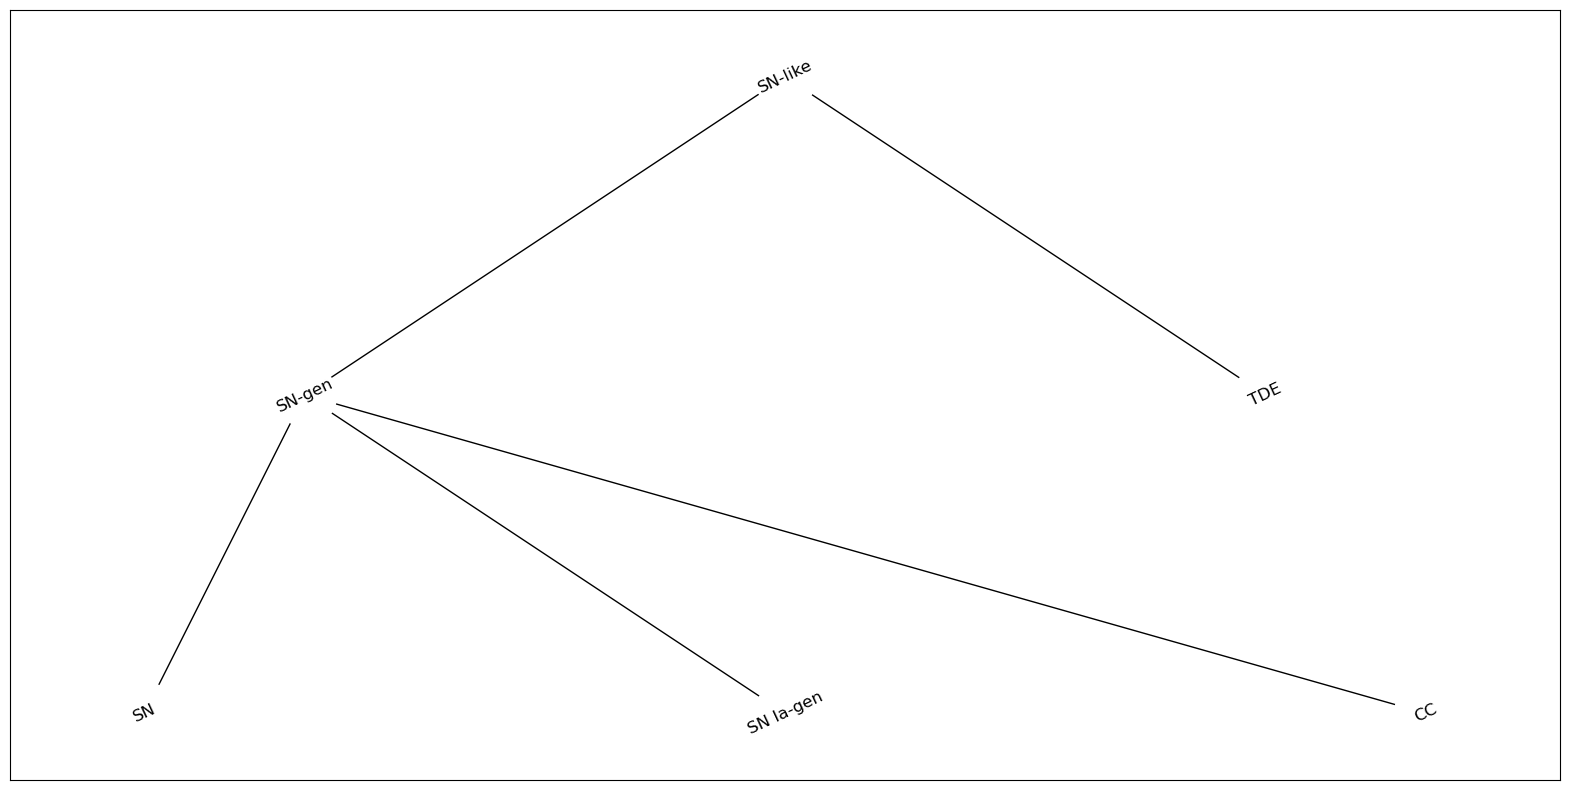

In [10]:
# Encode positions of graph - purely for drawing purposes
pos = hierarchy_pos(G, 'SN-like')
#print(pos)

fig = plt.figure(1, figsize=(20,10))
nx.draw_networkx(G, pos=pos, nodelist=vertices, node_color='white', with_labels=False, node_size=2000, arrows=False)
text = nx.draw_networkx_labels(G, pos)

#Uncomment if need to rotate the labels for a more advanced label system.
for _, t in text.items():
     t.set_rotation(25) 

plt.show()

In [11]:
for i,k in class_new.items():
    print(class_new[i][0]*class_new[i][1])

4141.5
4141.5
4141.5
4141.5


### Working on Implementing Taxonomy Now

In [12]:
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
graph = config.graph
edges = config.graph['edges']
verstices = config.graph['vertices']
weight_dict = config.class_weights
height = config.graph['height']
root = config.graph['root']

In [13]:
from superphot_plus.config import SuperphotConfig
from superphot_plus.model.taxonomy import Taxonomy

config = SuperphotConfig.from_file("config.yaml")

taxonomy = Taxonomy(config)
print(taxonomy)

mapping: {'SN Ic-pec': 'SN Ic-gen', 'SN IIb': 'SN II-like', 'SN II': 'SN II-like', 'SN Icn': 'SN Ic-gen', 'SN Ib': 'SN Ib-gen', 'SN IIP': 'SN II-like', 'SN Ic': 'SN Ic-gen', 'SN IIL': 'SN II-like', 'SN II-pec': 'SN II-like', 'SN Ic-Ca-rich': 'SN Ic-gen', 'SLSN-II': 'SN IIn-like', 'SN Ic-BL': 'SN Ic-gen', 'SN Ibn': 'SN Ib-gen', 'SN Ib-pec': 'SN Ib-gen', 'SN IIn': 'SN IIn-like', 'SN II-like': 'SN II-gen', 'SN Ib/c': 'SN Ib/c-gen', 'SN Ic-gen': 'SN Ib/c-gen', 'SN Ib-gen': 'SN Ib/c-gen', 'SN IIn-like': 'SN II-gen', 'SN Ia-CSM': 'SN Ia-gen', 'SN II-gen': 'CC', 'SN Ia-91bg-like': 'SN Ia-gen', 'SLSN-I': 'CC', 'SN Ia': 'SN Ia-gen', 'SN Ia-SC': 'SN Ia-gen', 'SN Ia-pec': 'SN Ia-gen', 'SN Iax': 'SN Ia-gen', 'SN Ib/c-gen': 'CC', 'SN Ia-91T': 'SN Ia-gen'}
weight_dict: {'SN': [49.30357142857143, 84], 'TDE': [39.070754716981135, 106], 'SN Ia-gen': [0.363863995782815, 11382], 'CC': [0.829295154185022, 4994]}
graph: {'edges': [['SN-like', 'SN-gen'], ['SN-like', 'TDE'], ['SN-gen', 'SN'], ['SN-gen', 'SN 

In [14]:
#all_paths, pathlengths, mask_list, y_dict = taxonomy.calc_paths_and_masks()

In [15]:
#all_paths

In [16]:
#pathlengths

In [17]:
#mask_list

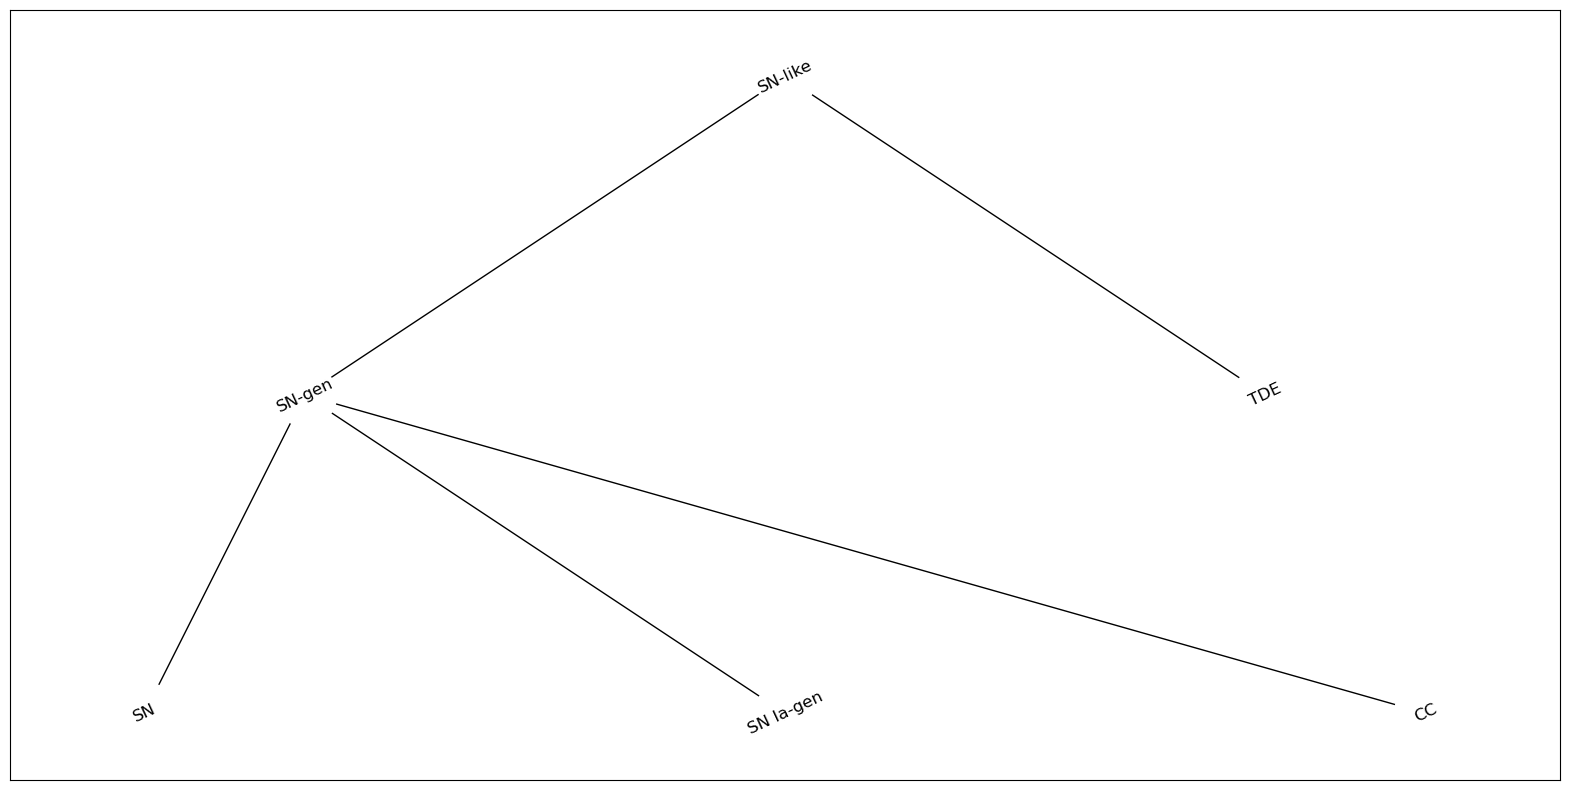

In [18]:
taxonomy.draw_graph()

### Cross-Entropy Loss Wrapper

Have access to config in mlp.py -> define taxonomy there -> load whxe

In [19]:
import torch
import torch.nn as nn
from superphot_plus.model.taxonomy import Taxonomy

class hier_xe_loss(nn.Module):
    
    def __init__(self, taxo: Taxonomy):
        super().__init__()
        self.all_paths, self.pathlengths, self.mask_list, self.y_dict = taxo.calc_paths_and_masks()
        self.alpha = taxo.alpha
        self.class_weights = taxo.class_weights

    def __str__(self):
        string = f"masklist: {self.mask_list}\npathlengths: {self.pathlengths}"
        string += f"\nall_paths: {self.all_paths}\nalpha: {self.alpha}\nclass_weights: {self.class_weights}"
        return string 
    
    """
    Copied from hxe-for-tda by Ashley Villar.
    """
    def masked_softmax(vec, mask, dim=1, epsilon=1e-10):
        # Applies the mask
        # Note, this is multiplying torch.tensors, so it just multiplies the elements, not dot product -_-
        masked_vec = vec * mask.float()

        # exp(masked_vec) -> exp(0) for masked-out, exp(vec[i]) for valid elements
        # each exps_i = e^[masked_vec_{i}]
        exps = torch.exp(masked_vec)
        
        # Need to apply masking again because we need to zero out masked entries again as exp(0)=1
        masked_exps = exps * mask.float()

        # Sums the unmasked exponentials across the class dimension and adds epsilon 
        masked_sums = masked_exps.sum(dim, keepdim=True) + epsilon 

        # Computes softmax only where mask = 1, preserves original values where mask = 0
        final_vec = masked_exps/masked_sums + ((1-mask) * vec)
        return final_vec

    def get_label(self, y):
        return self.y_dict[y]

    def get_weight(self, y):
        return self.class_weights[y]

    def forward(self, y_pred, y_actual, alpha=0.5):
        final_sum = 0
        
        # sets the first column/entry of y_pred to 1 such that the root node 
	    # always has a fixed probability of 1, or log-prod = 0
        y_pred[:, 0] = 1.0 

        labels = torch.clone(y_actual)
        labels = torch.apply_(self.get_label)
        weights = torch.clone(y_actual)
        weights = torch.apply_(self.get_weight)
        
        # Applies the different parent masks made above to the y_pred to normalize 
	    # child probabilities for each set of children/leaves
        for i,mask in enumerate(mask_list):
            y_pred = self.masked_softmax(y_pred, mask)

        # Apply log to the conditional probabilities
        y_pred = y_pred.log()

        # Apply the lambda = exp(-ah(c)) term
        y_pred = y_pred * np.exp(-alpha * (pathlengths - 1))

        # y_pred*y_actual.sum -> picks out log probs along hierarchical path + 
        # 					   sums along this path giving us log joint prob of path up tree
        # target_weights * (...) -> This is the multiply by W(c)
        # .mean() -> normalize by the batch size
        final_sum = (weights * (y_pred*y_actual).sum(dim=1)).mean()

        return -final_sum
    
    

In [20]:
dummy = hier_xe_loss(taxonomy)
print(dummy)

masklist: [tensor([0, 1, 0, 0, 1, 0]), tensor([1, 0, 0, 1, 0, 1])]
pathlengths: tensor([3, 2, 1, 3, 2, 3])
all_paths: [['SN-like', 'SN-gen', 'SN'], ['SN-like', 'TDE'], ['SN-like'], ['SN-like', 'SN-gen', 'CC'], ['SN-like', 'SN-gen'], ['SN-like', 'SN-gen', 'SN Ia-gen']]
alpha: 0.5
class_weights: {'SN': [8.217261904761905, 84], 'TDE': [6.511792452830188, 106]}
